In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
# Charger les fichiers
df_FS1_10HZ = pd.read_csv('FS1.txt',sep='\t',header=None).stack().reset_index(drop=True)
df_PS2_100HZ=pd.read_csv('PS2.txt',sep='\t',header=None).stack().reset_index(drop=True)
df_profile=pd.read_csv('profile.txt',sep='\t',header=None)

# Afficher les premières lignes du dataframe
print(len(df_FS1_10HZ))
print(len(df_PS2_100HZ))
print(len(df_profile))

1323000
13230000
2205


In [3]:
# Séléction des 2000 premières valeurs pour le training set 
df_FS1_10HZ_ML = df_FS1_10HZ.iloc[:2205].reset_index(drop=True)
## Vu la différence de fréquence on doit choisir une valeur toute les 10 valeurs 
df_PS2_100HZ_ML=df_PS2_100HZ.iloc[::10].iloc[:2205].reset_index(drop=True)

df_profile_ML=df_profile.iloc[:2205,1].reset_index(drop=True)
print(len(df_FS1_10HZ_ML))
print(len(df_PS2_100HZ_ML))
print(len(df_profile_ML))

2205
2205
2205


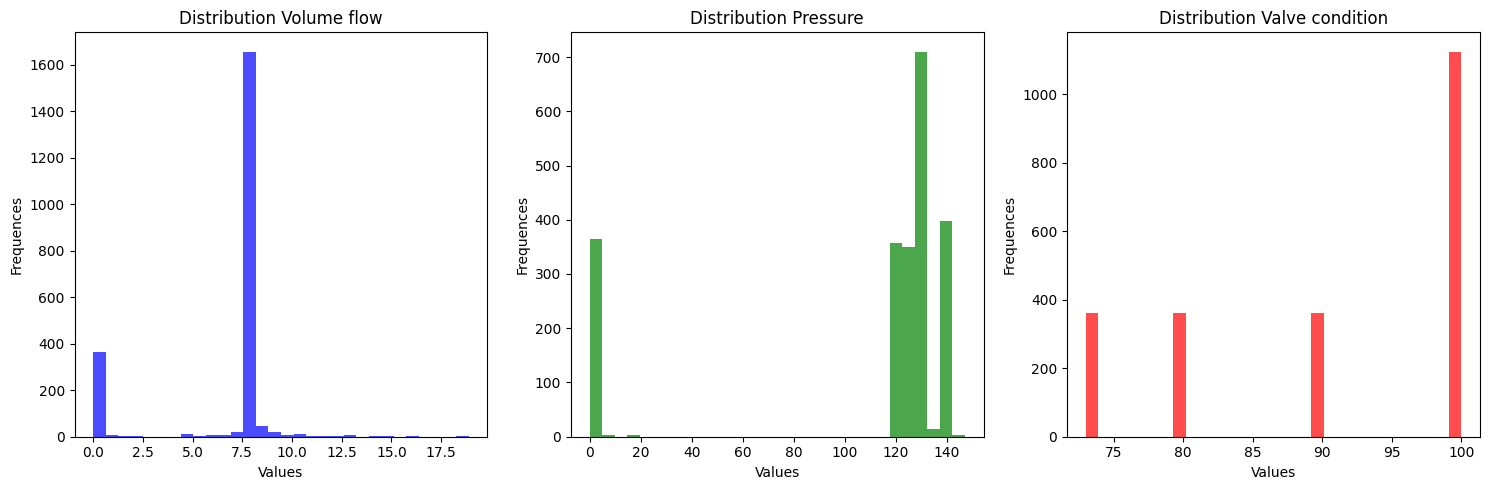

In [4]:
# Créer la figure et les sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 ligne, 3 colonnes

# Contrôler la distribution des valeurs 
axes[0].hist(df_FS1_10HZ_ML, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Distribution Volume flow')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequences')

axes[1].hist(df_PS2_100HZ_ML, bins=30, color='green', alpha=0.7)
axes[1].set_title('Distribution Pressure')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequences')

axes[2].hist(df_profile_ML, bins=30, color='red', alpha=0.7)
axes[2].set_title('Distribution Valve condition')
axes[2].set_xlabel('Values')
axes[2].set_ylabel('Frequences')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

In [5]:
#concatination de la Data Frame
Data_ML=pd.DataFrame()
Data_ML['df_FS1_10HZ_ML']=df_FS1_10HZ_ML
Data_ML['df_PS2_100HZ_ML']=df_PS2_100HZ_ML
Data_ML['df_profile_ML']=df_profile_ML
print(len(Data_ML))

2205


In [6]:
#Apprentissage 
X=np.array(Data_ML[['df_FS1_10HZ_ML', 'df_PS2_100HZ_ML']])
Y=np.array(Data_ML['df_profile_ML'])
# Normaliser les données
scaler = MinMaxScaler()  # Vous pouvez aussi utiliser StandardScaler pour la standardisation 
X_scaled = scaler.fit_transform(X)

#Split train et test 
X_train = X_scaled[:2000]
y_train = Y[:2000]
X_test = X_scaled[2000:]
y_test = Y[2000:]

# Créer et entraîner le modèle

model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur quadratique moyenne racine (RMSE) : {rmse}")

Erreur quadratique moyenne (MSE) : 128.11843579008882
Erreur quadratique moyenne racine (RMSE) : 11.318941460670642


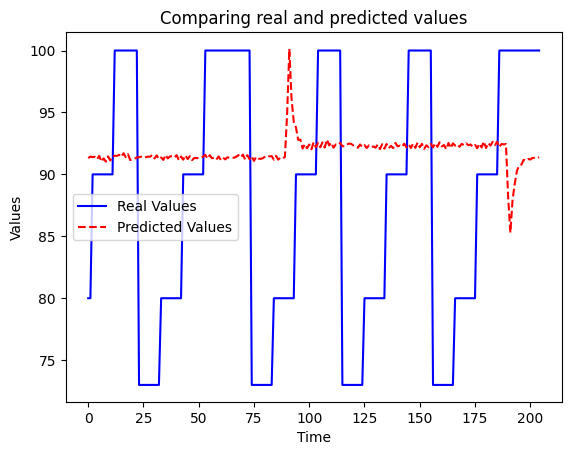

In [7]:
# Affichage des résultas 
# Tracer les valeurs réelles
plt.plot(y_test, label='Real Values', color='blue')

# Tracer les valeurs prédites
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')

# Ajouter un titre et des labels
plt.title('Comparing real and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

In [8]:
# => Comportement cyclique modèles non adapté on pouvait travailler avec ARAMA, et les transformations adéquates


In [9]:
# Transformation en sinus et cosinus pour la valeur cyclique (target)
Data_ML['sin_df_profile_ML'] = np.sin(2 * np.pi * Data_ML['df_profile_ML'] / 24)
Data_ML['cos_df_profile_ML'] = np.cos(2 * np.pi * Data_ML['df_profile_ML'] / 24)

In [10]:
Y=np.array(Data_ML[['sin_df_profile_ML', 'cos_df_profile_ML']])

In [11]:
y_train = Y[:2000]
y_test = Y[2000:]

In [13]:
model = RandomForestRegressor(n_estimators=20)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20)

In [14]:
y_pred = model.predict(X_test)

In [27]:
# Reconvertir les prédictions sin et cos en valeur cyclique
predicted_sin = y_pred[:, 0]
predicted_cos = y_pred[:, 1]
# Calculer la valeur cyclique prédite (utilisation de l'arc tangent)
predicted_target = np.arctan2(predicted_sin, predicted_cos) * (24 / (2 * np.pi))

In [28]:
Data_ML['df_profile_ML'][2000:]


2000     80
2001     80
2002     90
2003     90
2004     90
       ... 
2200    100
2201    100
2202    100
2203    100
2204    100
Name: df_profile_ML, Length: 205, dtype: int64

In [29]:
# Évaluation
mse = mean_squared_error(np.array(Data_ML['df_profile_ML'][2000:]), predicted_target)
rmse = np.sqrt(mse)

print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur quadratique moyenne racine (RMSE) : {rmse}")

Erreur quadratique moyenne (MSE) : 7303.132216548342
Erreur quadratique moyenne racine (RMSE) : 85.45836539829405


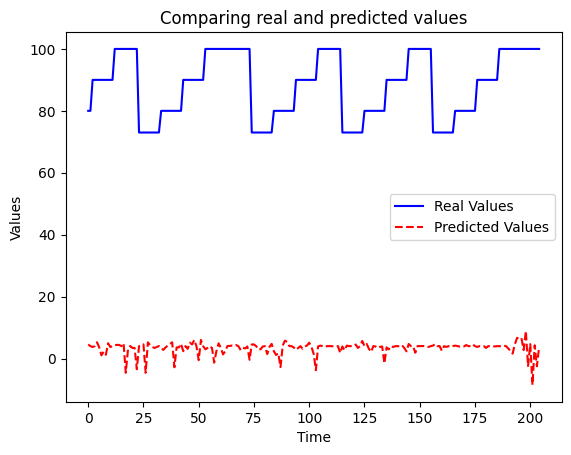

In [30]:
# Affichage des résultas 
# Tracer les valeurs réelles
plt.plot(list(Data_ML['df_profile_ML'][2000:]), label='Real Values', color='blue')

# Tracer les valeurs prédites
plt.plot(predicted_target, label='Predicted Values', color='red', linestyle='--')

# Ajouter un titre et des labels
plt.title('Comparing real and predicted values')
plt.xlabel('Time')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.show()

In [34]:
# Sauvegarder le modèle avec pickle
with open("model_rf.pkl", "wb") as f:
    pickle.dump(model, f)

print("Modèle sauvegardé sous 'model_rf.pkl'")

Modèle sauvegardé sous 'model_rf.pkl'


In [33]:
Data_ML.head()

,df_FS1_10HZ_ML,df_PS2_100HZ_ML,df_profile_ML,sin_df_profile_ML,cos_df_profile_ML
0,8.990,125.500,100,0.866025,0.5
1,0.770,15.648,100,0.866025,0.5
2,0.641,6.266,100,0.866025,0.5
3,0.006,3.250,100,0.866025,0.5
4,0.000,2.008,100,0.866025,0.5


In [36]:
Data_ML.to_csv("2205_Cycle.csv",index=False)